# Run Kubeflow pipeline to AWS

This notebook is to see how we set up and runnning our kubeflow pipeline on AWS.

This notebook is composed of two main parts:
* The first part is to set up the dependencies of our project as well as to configure all the services correctly.
* The second part is to set up our kubeflow pipeline.

## Setup Dependencies

## This step is to setup an aws eks cluster. Goto "Build pipeline" to see the kubeflow pipeline step.

### Pip

In [ ]:
!pip install --disable-pip-version-check -q pip --upgrade > /dev/null
!pip install --disable-pip-version-check -q wrapt --upgrade > /dev/null

### KFP

In [ ]:
#!pip install kfp --upgrade

### AWS CLI and AWS Python SDK (boto3)

In [ ]:
!pip install --disable-pip-version-check -q awscli==1.18.216 boto3==1.16.56 botocore==1.19.56

### SageMaker

In [ ]:
!pip install --disable-pip-version-check -q sagemaker==2.29.0
!pip install --disable-pip-version-check -q smdebug==1.0.1
!pip install --disable-pip-version-check -q sagemaker-experiments==0.1.26

#### Tensorflow

In [ ]:
!pip install --disable-pip-version-check -q tensorflow==2.3.1

#### Sklearn

In [ ]:
!pip install sklearn

#### Hugging Face Transformers (Bert)

In [ ]:
!pip install --disable-pip-version-check -q transformers==3.5.1

#### Other (Matplotlib etc.)

In [ ]:
!pip install --disable-pip-version-check -q matplotlib==3.1.3

#### AWS CLI and Credentials (Optional)
if you are running atouside of an AWS account, you should uncomment and run the cells below.

In [3]:
# !pip install awscli
# !mkdir ~/.aws
# %%writefile ~/.aws/credentials

# [default]
# aws_access_key_id = <ACCESS_KEY_ID>
# aws_secret_access_key = <SECRET_ACCESS_KEY>
# %%writefile ~/.aws/config

# [default]
# region=<REGION_NAME> # us-east-1

#### Summarize

In [ ]:
!pip list

In [ ]:
setup_dependencies_passed = True
%store setup_dependencies_passed
%store


In [ ]:
%store


### Restart the kernel

In [ ]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

## Set up environment

### Create S3 Bucket

In [ ]:
import boto3
import sagemaker

session = boto3.session.Session()
region = session.region_name
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

s3 = boto3.Session().client(service_name="s3", region_name=region)

In [ ]:
setup_s3_bucket_passed = False
print("Default bucket: {}".format(bucket))


### Verify S3_Bucket Bucket Creation

In [ ]:
from botocore.client import ClientError

response = None

try:
    response = s3.head_bucket(Bucket=bucket)
    print(response)
    setup_s3_bucket_passed = True
except ClientError as e:
    print("[ERROR] Cannot find bucket {} in {} due to {}.".format(bucket, response, e))

%store setup_s3_bucket_passed
%store

### Update IAM Roles and Policies

In [ ]:
import boto3
import sagemaker
import time
from time import gmtime, strftime

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
region = boto3.Session().region_name

from botocore.config import Config

config = Config(retries={"max_attempts": 10, "mode": "adaptive"})

iam = boto3.client("iam", config=config)

#### Get SageMaker Execution Role Name

In [ ]:
role_name = role.split("/")[-1]

print("Role name: {}".format(role_name))

###### Pre-Requisite: SageMaker notebook instance ExecutionRole contains AdministratorAccess Policy.

In [ ]:
setup_iam_roles_passed = False
admin = False

post_policies = iam.list_attached_role_policies(RoleName=role_name)["AttachedPolicies"]
for post_policy in post_policies:
    if post_policy["PolicyName"] == "AdministratorAccess":
        admin = True
        setup_iam_roles_passed = True
        print("[OK] You are all set up to continue with this workshop!")
        break

if not admin:
        print("*************** [ERROR] SageMakerExecutionRole needs the AdministratorAccess policy attached. *****************")

#### Final Check

In [ ]:
# role = iam.get_role(RoleName=role_name)
post_policies = iam.list_attached_role_policies(RoleName=role_name)["AttachedPolicies"]

required_policies = [
    "AdministratorAccess",
#     "SecretsManagerReadWrite",
#     "IAMFullAccess",
#     "AmazonS3FullAccess",
#     "AmazonAthenaFullAccess",
#     "ComprehendFullAccess",
#     "AmazonEC2ContainerRegistryFullAccess",
#     "AmazonRedshiftFullAccess",
#     "AWSStepFunctionsFullAccess",
#     "AmazonSageMakerFullAccess",
#     "AmazonKinesisFullAccess",
#     "AmazonKinesisFirehoseFullAccess",
#     "AmazonKinesisAnalyticsFullAccess",
]

admin = False

for post_policy in post_policies:
    if post_policy["PolicyName"] == "AdministratorAccess":
        admin = True
        try:
            required_policies.remove(post_policy["PolicyName"])
        except:
            break
    else:
        try:
            required_policies.remove(post_policy["PolicyName"])
        except:
            pass

if not admin and len(required_policies) > 0:
    print("*************** [ERROR] RE-RUN THIS NOTEBOOK *****************")
    for required_policy in required_policies:
        print("Not Attached: {}".format(required_policy))
else:
    setup_iam_roles_passed = True
    print("[OK] You are all set up to continue with this workshop!")

In [ ]:
%store setup_iam_roles_passed
%store


### Copy data from Public S3 to Private S3

## Build Pipeline

In [3]:
!pip3 install kfp --upgrade

  Using cached protobuf-3.20.3-py2.py3-none-any.whl (162 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.18.1
    Uninstalling protobuf-3.18.1:
      Successfully uninstalled protobuf-3.18.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-macos 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.2 which is incompatible.


In [4]:
import kfp
from kfp import components
from kfp.components import func_to_container_op
from kfp import dsl
from kfp.aws import use_aws_secret

TypeError: bases must be types

### Import dataset - 20newsgroups sklearn

In [1]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
import time

Here, we will use the 20news datasets from sklearn to test the pipeline.

In [2]:
print("Loading dataset...")
t0 = time.time()
data = fetch_20newsgroups(
    shuffle=True,
    random_state=1,
    remove=("headers", "footers", "quotes"),
)
# data_samples = data[:2000]
print("done in %0.3fs." % (time.time() - t0))

Loading dataset...
done in 1.012s.


In [3]:
# sneak peek of the news articles
for idx in range(2):
    print(data.data[idx],'\n\n','#'*100, '\n\n')

Well i'm not sure about the story nad it did seem biased. What
I disagree with is your statement that the U.S. Media is out to
ruin Israels reputation. That is rediculous. The U.S. media is
the most pro-israeli media in the world. Having lived in Europe
I realize that incidences such as the one described in the
letter have occured. The U.S. media as a whole seem to try to
ignore them. The U.S. is subsidizing Israels existance and the
Europeans are not (at least not to the same degree). So I think
that might be a reason they report more clearly on the
atrocities.
	What is a shame is that in Austria, daily reports of
the inhuman acts commited by Israeli soldiers and the blessing
received from the Government makes some of the Holocaust guilt
go away. After all, look how the Jews are treating other races
when they got power. It is unfortunate.
 

 #################################################################################################### 









Yeah, do you expect people to rea

In [3]:
# put your data into a dataframe
news_df = pd.DataFrame({'News': data.data,
                       'Target': data.target})

# get dimensions of data
print("shape : ", news_df.shape)
print("head : \n", news_df.head())

shape :  (11314, 2)
head : 
                                                 News  Target
0  Well i'm not sure about the story nad it did s...      17
1  \n\n\n\n\n\n\nYeah, do you expect people to re...       0
2  Although I realize that principle is not one o...      17
3  Notwithstanding all the legitimate fuss about ...      11
4  Well, I will have to change the scoring on my ...      10


In [4]:
# replace target names from target numbers in our news data frame
news_df['Target_name'] = news_df['Target'].apply(lambda x: data.target_names[x])
news_df.head()

,News,Target,Target_name
0,Well i'm not sure about the story nad it did s...,17,talk.politics.mideast
1,"\n\n\n\n\n\n\nYeah, do you expect people to re...",0,alt.atheism
2,Although I realize that principle is not one o...,17,talk.politics.mideast
3,Notwithstanding all the legitimate fuss about ...,11,sci.crypt
4,"Well, I will have to change the scoring on my ...",10,rec.sport.hockey


/opt/homebrew/Caskroom/miniforge/base/envs/tftest/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'talk.politics.mideast'),
  Text(1, 0, 'alt.atheism'),
  Text(2, 0, 'sci.crypt'),
  Text(3, 0, 'rec.sport.hockey'),
  Text(4, 0, 'soc.religion.christian'),
  Text(5, 0, 'comp.sys.mac.hardware'),
  Text(6, 0, 'sci.med'),
  Text(7, 0, 'sci.electronics'),
  Text(8, 0, 'comp.graphics'),
  Text(9, 0, 'misc.forsale'),
  Text(10, 0, 'talk.religion.misc'),
  Text(11, 0, 'talk.politics.guns'),
  Text(12, 0, 'rec.motorcycles'),
  Text(13, 0, 'rec.autos'),
  Text(14, 0, 'comp.os.ms-windows.misc'),
  Text(15, 0, 'comp.windows.x'),
  Text(16, 0, 'comp.sys.ibm.pc.hardware'),
  Text(17, 0, 'sci.space'),
  Text(18, 0, 'rec.sport.baseball'),
  Text(19, 0, 'talk.politics.misc')])

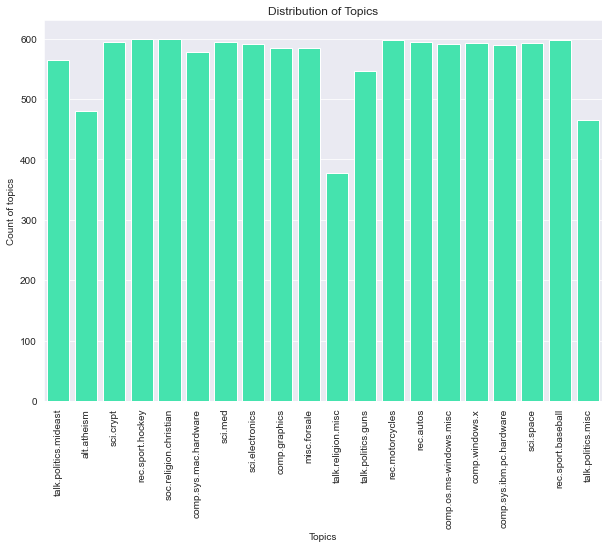

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
# plot distribution of topics in news data
fig = plt.figure(figsize=[10,7])
ax = sns.countplot(news_df['Target_name'], color=sns.xkcd_rgb['greenish cyan'])
plt.title('Distribution of Topics')
plt.xlabel('Topics')
plt.ylabel('Count of topics')
plt.xticks(rotation=90)

I will pass "paragraph" into the Kubeflow pipeline parameter.

In [8]:
paragraph = news_df['News']
paragraph

0        Well i'm not sure about the story nad it did s...
1        \n\n\n\n\n\n\nYeah, do you expect people to re...
2        Although I realize that principle is not one o...
3        Notwithstanding all the legitimate fuss about ...
4        Well, I will have to change the scoring on my ...
                               ...                        
11309    Danny Rubenstein, an Israeli journalist, will ...
11310                                                   \n
11311    \nI agree.  Home runs off Clemens are always m...
11312    I used HP DeskJet with Orange Micros Grappler ...
11313                                          ^^^^^^\n...
Name: News, Length: 11314, dtype: object

### Kubeflow Pipeline - Components

***

#### Example: Kubeflow pipeline

Kubeflow use Docker image to create components of the pipeline.
* image: In the example below, the image used is a custom image to do preprocessing in a given text. It is from this image that kubeflow will create its component.
* command: Then we ask him to launch a file 'preprocess_input_text.py' present in the image.
* arguments: As argument, we let it enter a paragraph
* file_outputs: The outputs is a csv file named 'paragraph.csv' This output file will be the input of the next components of the pipeline.

In [7]:
def preprocess_input_text_op(paragraph):
    return dsl.ContainerOp(
        name='preprocess_input_text',
        image='thekenken/preprocess_input_text:latest',
        command=['python', './preprocess_input_text.py'],
        arguments=['--paragraph', paragraph],
        file_outputs={
            'paragraph': '/app/paragraph.csv',
        }
    )

The ```dsl.ContainerOp()``` function needs an image that is present in the docker hub repository. If you want to use an image present in your local machine, it will not work, you need to push to docker hub or amazon hub for docker images.

You can check how we create those images in the "../kubeflow" directory of this GitHub repository.

***

This is the pipeline we will use for topic modeling.

We have in total of 7 steps:

![](../img/topic_modeling_pipeline_gcp.png)

#### Preprocess Input

In this first step, we will clean up the input paragraph as little as possible, and split it by sentence, to obtain an output array of sentences instead of paragraphs. If we make it enter 5 paragraph. In the output, we will have an array of 5 tables of sentences per paragraph.

In [9]:
def preprocess_input_text_op(paragraph):
    return dsl.ContainerOp(
        name='preprocess_input_text',
        image='thekenken/preprocess_input_text:latest',
        # image='python:3.8-slim',
        # command=["python", -u, -m, "kfp_component.launcher"],
        command=['python', './preprocess_input_text.py'],
        # command=['python', './preprocess_input_text/preprocess_input_text.py'],
        arguments=['--paragraph', paragraph],
        file_outputs={
            'paragraph': '/app/paragraph.csv',
        }
    )

#### Sentence Embedding

In this step, we will use sentence embedding which will represent all the sentences in vectors. This will encode the meaning of the sentence as a vector. If two sentences are very close (in meaning) then the vector will also be very close

Example of representation of embedding vectors but for words:
![](../img/word_embedding.png)

For the embedding, we will use ```embed = spacy.load("en_core_web_sm")``` for purpose of lightweight
Otherwise, there is also USE (Universal-Sentence-Encoder) made by Google available from Tensorflow-hub.

The input of this component is the preprocessed texts from the previous component. This will come out an array with multiple vectors 'embedding.npy'.

In [10]:
# preprocess_input_text_op.output
def embedding_op(text):
    return dsl.ContainerOp(
        name='embedding',
        image='thekenken/embedding:latest',
        # command=['python', './embedding/embeddings.py'],
        command=['python', './embeddings.py'],
        arguments=['--paragraph', text],
        file_outputs={
            'embeddings': '/app/embedding.npy',
        }
    )

#### PCA - dimension reduction

This embedding is then sent to the PCA (Principal Component Analysis) which is a dimension reduction. The objective is to reduce the dimension while keeping 95% of the information.


In [11]:
# embedding_op.output
def pca_dimension_reduction_op(embeddings):
    return dsl.ContainerOp(
        name='pca_dimension_reduction',
        image='thekenken/pca:latest',
        command=['python', './pca.py'],
        arguments=['--embeddings', embeddings],
        file_outputs={
            'pca_result': '/app/pca_result.npy',
        }
    )

#### Find optimal number of clusters - Kmeans

We will then do clustering with KMeans which will group sentences with similar meaning. The objective is to get the sentences closest to the center of each group. We will create a document that groups all the sentences or paragraphs by clusters, for example if we have 5 clusters we will have 5 documents of the most representative sentences.


In [12]:
def find_optimal_k_cluster_op(pca_result):
    return dsl.ContainerOp(
        name='find_optimal_k_cluster',
        image='thekenken/find_optimal_number_of_clusters:latest',
        command=['python', './find_optimal_k_cluster.py'],
        arguments=['--pca_result', pca_result],
        file_outputs={
            'optimal_k_cluster': '/app/optimal_k_cluster.npy',
        }
    )


def kmeans_op(n_clusters_optimal, pca_result):
    return dsl.ContainerOp(
        name='kmeans',
        image='thekenken/kmeans:latest',
        command=['python', './kmeans.py'],
        arguments=['--n_clusters_optimal', n_clusters_optimal,
                   '--pca_result', pca_result],
        file_outputs={
            'top_nearest_indices_by_clusters': '/app/top_nearest_indices_by_clusters.npy',
        }
    )

def create_dataframe_op(top_nearest_indices_by_clusters, text):
    return dsl.ContainerOp(
        name='create_dataframe_from_top_nearest_indices_by_clusters',
        image='thekenken/create_df_from_top_nearest_indices:latest',
        command=['python', './create_df.py'],
        arguments=['--top_nearest_indices_by_clusters', top_nearest_indices_by_clusters,
                   '--text', text],
        file_outputs={
            'documents': '/app/documents.csv',
        }
    )


#### TF-IDF

This brings us to the last part of our pipeline, the topic analysis: TF-IDF. TF-IDF (term frequency-inverse document frequency) is a statistical measure that evaluates the relevance of a word to a document in a document collection.
We will visualize the results using this method by displaying the most relevant words in each document/cluster.

In [13]:
def tf_idf_op(documents_path):
    return dsl.ContainerOp(
        name='TF-IDF',
        image='thekenken/tf_idf:latest',
        command=['python', './tf_idf.py'],
        arguments=["--documents_path", documents_path],
        file_outputs={
            'tf_idf': '/app/top_words.csv',
        }
    )

### Pipeline - Assemble components

Earlier we create all the steps/components of the topic modeling pipeline, now we need to assemble them to create a valid kubeflow pipeline.

In [15]:
@dsl.pipeline(
    name='Topic Modeling Pipeline',
    description='Topic Modeling Pipeline'
)
def topic_modeling_pipeline(paragraph):
    _preprocess_input_text = preprocess_input_text_op(paragraph)

    ''' .after() is needed to tell the line of the pipeline'''
    _embedding = embedding_op(dsl.InputArgumentPath(_preprocess_input_text.outputs['paragraph'])).after(
        _preprocess_input_text)

    _pca_dimension_reduction = pca_dimension_reduction_op(
        dsl.InputArgumentPath(_embedding.outputs['embeddings'])).after(_embedding)

    _find_optimal_k_cluster = find_optimal_k_cluster_op(
        dsl.InputArgumentPath(_pca_dimension_reduction.outputs['pca_result'])).after(_pca_dimension_reduction)

    _kmeans = kmeans_op(dsl.InputArgumentPath(_find_optimal_k_cluster.outputs['optimal_k_cluster']),
                        dsl.InputArgumentPath(_pca_dimension_reduction.outputs['pca_result'])).after(
        _find_optimal_k_cluster, _pca_dimension_reduction)

    _create_dataframe = create_dataframe_op(dsl.InputArgumentPath(_kmeans.outputs['top_nearest_indices_by_clusters']),
                                            dsl.InputArgumentPath(_preprocess_input_text.outputs['paragraph'])).after(
        _kmeans,
        _preprocess_input_text)

    _tf_idf = tf_idf_op(dsl.InputArgumentPath(_create_dataframe.outputs['documents'])).after(_create_dataframe)

    return _tf_idf

NameError: name 'dsl' is not defined

## Compile the Kubeflow pipeline

In [ ]:
kfp.compiler.Compiler().compile(
    pipeline_func=topic_modeling_pipeline,
    package_path='pipeline_topic_modeling_sagemaker.yaml')

In [ ]:
!pygmentize pipeline_topic_modeling.yaml

## Launch Pipeline on Kubernetes cluster

Here, I run the Kubeflow pipeline with the KFP SDK. You can check the run at the Kubeflow pipeline dashboard in the "run" or "experiments"

In [ ]:
client = kfp.Client()
client.create_run_from_pipeline_func(topic_modeling_pipeline, arguments={
    "paragraph": paragraph})
# "paragraph": "Machine learning (ML) is the scientific study of algorithms and statistical models that computer systems use to progressively improve their performance on a specific task. Machine learning algorithms build a mathematical model of sample data, known as ‘training data’, in order to make predictions or decisions without being explicitly programmed to perform the task. Machine learning algorithms are used in the applications of email filtering, detection of network intruders, and computer vision, where it is infeasible to develop an algorithm of specific instructions for performing the task. Machine learning is closely related to computational statistics, which focuses on making predictions using computers. The study of mathematical optimization delivers methods, theory and application domains to the field of machine learning. Data mining is a field of study within machine learning, and focuses on exploratory data analysis through unsupervised learning.In its application across business problems, machine learning is also referred to as predictive analytics."})


![](../img/kfp_dashboard_run.png)

If it's working well, you should be able to see this:

![](../img/result_run_kfp.png)